# Test del modello SVM Cardio

Questo notebook esegue un **test** su un modello SVM addestrato per la previsione di problemi cardiaci.

### Funzionalità
1. Carica il modello `svm_cardio_model.pkl` e lo scaler `scaler.pkl`.
2. Carica il dataset di addestramento `prepared_cardio_train.csv`.
3. Esegue **prediction** su alcuni input di test predefiniti.
4. Calcola le principali **metriche** (accuratezza, precisione, recall, F1, AUC-ROC) sul test set.

Puoi modificare le **feature** in `test_inputs` per effettuare test personalizzati.

> **Nota**: il codice originale è pensato per essere eseguito come script (con `__file__`), ma qui è stato adattato per l’esecuzione in un notebook.


In [1]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import sys
from pathlib import Path

# Se i file sono nella stessa cartella del Notebook, puoi usare '.' come base
# Altrimenti specifica il path corretto, ad esempio Path('/content/drive/MyDrive/...') in Colab
base_path = Path('.')  # Modifica se necessario

# Percorsi ai file
model_path = base_path / 'svm_cardio_model.pkl'
scaler_path = base_path / 'scaler.pkl'
dataset_path = base_path / 'prepared_cardio_train.csv'

# Verifica esistenza file
if not model_path.exists():
    raise FileNotFoundError(f"Il file del modello non esiste nel percorso {model_path}")
if not scaler_path.exists():
    raise FileNotFoundError(f"Il file dello scaler non esiste nel percorso {scaler_path}")
if not dataset_path.exists():
    raise FileNotFoundError(f"Il file del dataset non esiste nel percorso {dataset_path}")

# Caricamento del modello e dello scaler
model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

print("Mean dello scaler caricato:", scaler.mean_)
print("Varianza dello scaler caricato:", scaler.var_)

# Definizione delle feature numeriche
numerical_features = ['age_years', 'BMI', 'ap_hi', 'ap_lo', 'bp_ratio']

# Verifica delle feature del modello
if not hasattr(model, 'feature_names_in_'):
    raise AttributeError("Il modello caricato non ha l'attributo 'feature_names_in_'.")

model_features = model.feature_names_in_
print("\nFeature attese dal modello:", list(model_features))

# Lista di diversi input per il test
test_inputs = [
    {
        "gender": [1],
        "ap_hi": [120],
        "ap_lo": [80],
        "cholesterol": [1],
        "gluc": [1],
        "smoke": [0],
        "alco": [0],
        "active": [1],
        "BMI": [24.22],
        "bp_ratio": [1.5],
        "age_years": [40]
    },
    {
        "gender": [0],
        "ap_hi": [130],
        "ap_lo": [85],
        "cholesterol": [2],
        "gluc": [1],
        "smoke": [1],
        "alco": [0],
        "active": [0],
        "BMI": [30.5],
        "bp_ratio": [1.7],
        "age_years": [55]
    },
    {
        "gender": [1],
        "ap_hi": [110],
        "ap_lo": [70],
        "cholesterol": [1],
        "gluc": [1],
        "smoke": [0],
        "alco": [1],
        "active": [1],
        "BMI": [22.0],
        "bp_ratio": [1.6],
        "age_years": [35]
    }
    # Aggiungi altri dizionari con valori diversi se necessario
]

# Funzione per eseguire la predizione su un singolo input
def predict_single_input(input_dict, test_num):
    input_data = pd.DataFrame(input_dict)
    
    # Stampa dei valori originali
    print(f"\nTest {test_num} - Valori Originali:")
    print(input_data)
    
    # Scaling
    input_data_scaled = input_data.copy()
    input_data_scaled[numerical_features] = scaler.transform(input_data[numerical_features])
    
    # Stampa dei valori scalati
    print(f"Test {test_num} - Valori Scalati:")
    print(input_data_scaled)
    
    # Reordinamento delle feature secondo il modello
    input_data_scaled = input_data_scaled[model_features]
    
    # Stampa delle feature
    print(f"Test {test_num}:")
    print("Feature attese dal modello:", list(model_features))
    print("Feature fornite:", input_data_scaled.columns.tolist())
    
    # Predizione
    if hasattr(model, "predict_proba"):
        prediction_proba = model.predict_proba(input_data_scaled)[:, 1]
        probability = prediction_proba[0] * 100
        print(f"La probabilità di avere problemi cardiaci è del {probability:.2f}%")
    else:
        print("Il modello non supporta 'predict_proba'.")
    
    # Funzione di decisione
    if hasattr(model, "decision_function"):
        decision = model.decision_function(input_data_scaled)
        print(f"Test {test_num} - Valore della funzione di decisione:", decision[0])
    else:
        print("Il modello non supporta 'decision_function'.")

# Iterazione sui test
for idx, data in enumerate(test_inputs, start=1):
    predict_single_input(data, idx)

# Caricamento del dataset originale
data = pd.read_csv(dataset_path)

# Separazione delle feature e del target
X = data.drop('cardio', axis=1)
y = data['cardio']

# Divisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predizione sui dati di test
y_pred = model.predict(X_test)

# Predizione delle probabilità se disponibile
if hasattr(model, "decision_function"):
    y_prob = model.decision_function(X_test)
elif hasattr(model, "predict_proba"):
    y_prob = model.predict_proba(X_test)[:, 1]
else:
    y_prob = None

# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

if y_prob is not None:
    roc_auc = roc_auc_score(y_test, y_prob)
else:
    roc_auc = "Non disponibile"

print("\n--- Valutazione del Modello sul Test Set ---")
print(f"Accuratezza: {accuracy:.4f}")
print(f"Precisione: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc if isinstance(roc_auc, str) else f'{roc_auc:.4f}'}")


c:\Users\066325758\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Mean dello scaler caricato: [ 52.82406198  27.44793095 126.43749725  81.26471408   1.55987263]
Varianza dello scaler caricato: [4.58249791e+01 2.74759148e+01 2.54732087e+02 8.35725918e+01
 2.01673990e-02]

Feature attese dal modello: ['gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'BMI', 'bp_ratio', 'age_years']

Test 1 - Valori Originali:
   gender  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active    BMI  \
0       1    120     80            1     1      0     0       1  24.22   

   bp_ratio  age_years  
0       1.5         40  
Test 1 - Valori Scalati:
   gender     ap_hi     ap_lo  cholesterol  gluc  smoke  alco  active  \
0       1 -0.403344 -0.138344            1     1      0     0       1   

        BMI  bp_ratio  age_years  
0 -0.615812 -0.421603  -1.894412  
Test 1:
Feature attese dal modello: ['gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'BMI', 'bp_ratio', 'age_years']
Feature fornite: ['gender', 'ap_hi', 'a

## Istruzioni
1. **Assicurati** di aver copiato i file:
   - `svm_cardio_model.pkl` (il tuo modello SVM addestrato)
   - `scaler.pkl` (lo StandardScaler o simile usato in fase di training)
   - `prepared_cardio_train.csv` (il dataset di addestramento, con la colonna `cardio`)
   
   nella **stessa cartella** di questo notebook (o in un percorso compatibile con `base_path`).

2. Avvia il notebook (ad es. con Jupyter, VSCode, Google Colab) e **esegui le celle**. Se tutto va bene, vedrai:
   - Le statistiche dello scaler (mean, var)
   - Le feature attese dal modello
   - L'output delle predizioni su alcuni input di test.
   - Le metriche finali sul test set (accuratezza, precision, recall, F1, AUC-ROC).

3. Se vuoi **aggiungere** altri test personalizzati, modifica la lista `test_inputs` con i dizionari dei nuovi parametri.

4. Se qualcosa non funziona (es. `FileNotFoundError`), controlla i percorsi dei file o le versioni delle librerie.


In [3]:
# ---------------------------------------
# Spiegazione SHAP su un singolo test
# ---------------------------------------

import shap
import matplotlib.pyplot as plt

# Scegliamo uno dei test di input (es. il primo)
test_num = 1
test_input = test_inputs[test_num - 1]

# Convertiamo in DataFrame
input_data = pd.DataFrame(test_input)

# Applichiamo lo scaling solo sulle feature numeriche
input_data_scaled = input_data.copy()
input_data_scaled[numerical_features] = scaler.transform(input_data[numerical_features])

# Re-ordiniamo le colonne come nel modello
input_data_scaled = input_data_scaled[model_features]

print(f"Test {test_num}: Dati di input (scalati) pronti per SHAP:")
display(input_data_scaled)

# Se il tuo modello è, ad esempio, un SVC con .predict_proba, shap.Explainer potrebbe funzionare direttamente;
# Altrimenti, potresti usare shap.KernelExplainer(...) con una funzione di predizione personalizzata.
try:
    # Esempio: shap.Explainer con i dati di training come background (rischio che sia un po' lento).
    # Puoi anche passare un campione di X_train se X_train è grande.
    
    # Prendiamo un piccolo campione come background per performance
    background_size = 100  # o quello che preferisci
    if len(X_train) > background_size:
        X_background = X_train.sample(background_size, random_state=42)
    else:
        X_background = X_train
    
    # Attenzione: lo scaling di X_train qui va fatto solo se X_train non è già scalato.
    # Se X_train non era già scalato, fallo ora:
    X_background_scaled = X_background.copy()
    X_background_scaled[numerical_features] = scaler.transform(X_background[numerical_features])
    X_background_scaled = X_background_scaled[model_features]

    # Creiamo l'explainer
    shap_explainer = shap.Explainer(
        model, 
        X_background_scaled, 
        feature_names=model_features
    )

    # Calcoliamo i valori SHAP per il singolo test
    shap_values = shap_explainer(input_data_scaled)

    # Stampiamo i valori shap
    print("\nSHAP values calcolati:")
    display(shap_values)
    
    # Proviamo a fare un waterfall plot (se la libreria shap è >= 0.40)
    st_fig = shap.plots.waterfall(shap_values[0], show=False)

    # Se vuoi visualizzare in Streamlit, sostituisci con st.pyplot(fig)
    # Qui, in Jupyter, usiamo matplotlib direttamente:
    plt.show()

except Exception as e:
    print("Impossibile generare la spiegazione SHAP:", e)


Test 1: Dati di input (scalati) pronti per SHAP:


,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI,bp_ratio,age_years
0,1,-0.403344,-0.138344,1,1,0,0,1,-0.615812,-0.421603,-1.894412


Impossibile generare la spiegazione SHAP: The passed model is not callable and cannot be analyzed directly with the given masker! Model: SVC(C=1, degree=2, gamma='auto', probability=True, random_state=42)


PermutationExplainer explainer: 2it [01:08, 68.92s/it]               


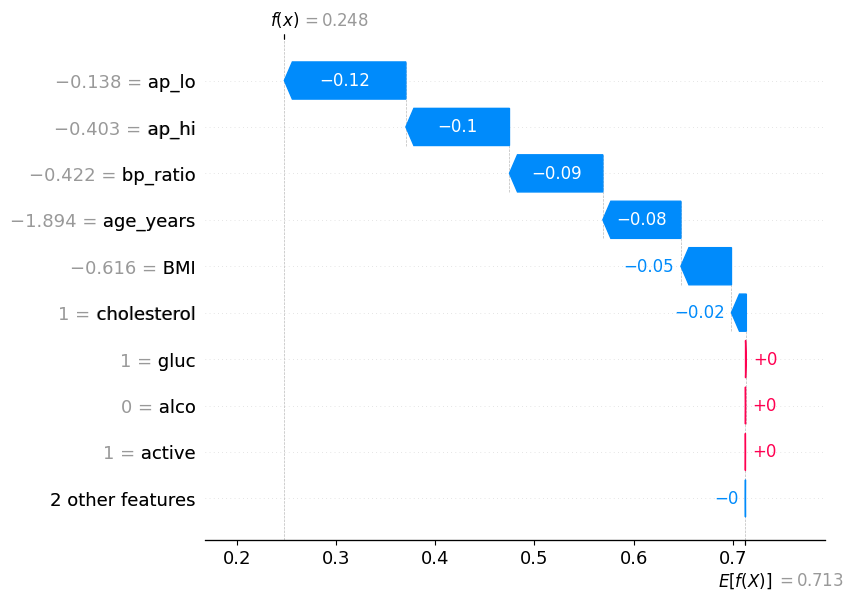

In [4]:
import shap

# Supponiamo che `X_background_scaled` sia un DataFrame (o array) di "background" già scalato,
# e contenga le stesse feature (e nello stesso ordine) di `model_features`.

# Passo una lambda che ritorna SOLO la probabilità di classe 1 (cardio=1).
# In questo modo SHAP ha un singolo output da spiegare.
explainer = shap.Explainer(
    lambda x: model.predict_proba(x)[:, 1],  
    X_background_scaled,
    feature_names=model_features
)

# Calcolo i valori SHAP di un singolo input
shap_values = explainer(input_data_scaled)

# Se vuoi un Waterfall Plot (per shap >= 0.40)
shap.plots.waterfall(shap_values[0])


c:\Users\066325758\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\066325758\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\066325758\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


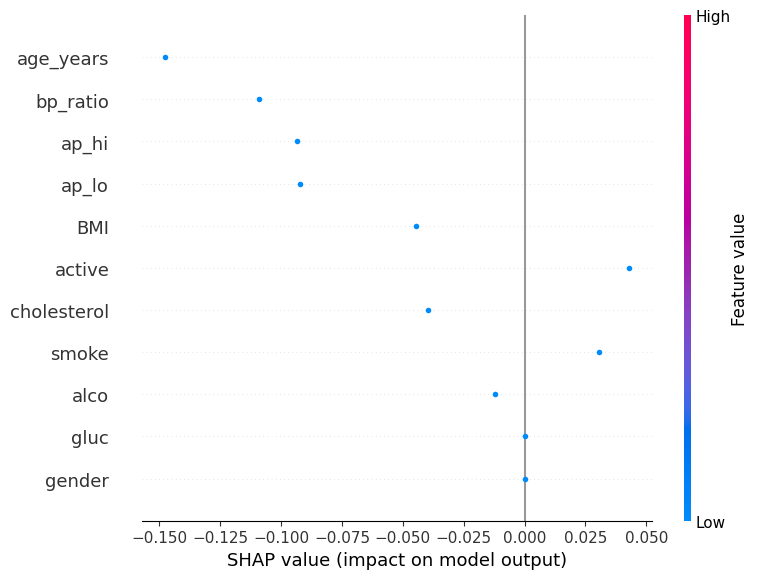

In [5]:
import shap

# Funzione di predizione, in questo caso la proba di classe 1
def predict_proba_class1(X):
    return model.predict_proba(X)[:, 1]

# Creo l'explainer
kernel_explainer = shap.KernelExplainer(
    model=predict_proba_class1,         # la funzione di predizione
    data=X_background_scaled,           # background (scaled)
    feature_names=model_features
)

# Calcolo i valori shap su 1 (o più) esempi
shap_values = kernel_explainer.shap_values(input_data_scaled, nsamples=100)

# shap_values con KernelExplainer di solito restituisce un array NxM
# dove N = numero di esempi, M = numero di feature

# Visualizziamo un summary_plot su quell'esempio (o waterfall se preferisci)
shap.summary_plot(shap_values, input_data_scaled, feature_names=model_features)
